##**Vegetable and Fruits Classification Model**

In [7]:
!pip install kaggle

In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [10]:
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition

Dataset URL: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition
License(s): CC0-1.0
 99% 1.97G/1.98G [00:26<00:00, 22.8MB/s]
100% 1.98G/1.98G [00:26<00:00, 80.4MB/s]


In [11]:
from zipfile import ZipFile
dataset = "/content/fruit-and-vegetable-image-recognition.zip"
with ZipFile(dataset, "r") as zfile:
  zfile.extractall()

### **Dependencies**

In [1]:
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

In [12]:
warnings.filterwarnings("ignore")

In [13]:
train_folder = "/content/train"
test_folder = "/content/test"
valid_folder = "/content/validation"

In [17]:
def num_of_classes(folder_path, folder_name):
  classes = [class_name for class_name in os.listdir(folder_path)]
  print(f"Number of classes in {folder_name} folder: {len(classes)}")

In [18]:
num_of_classes(train_folder, "train")
num_of_classes(test_folder, "test")
num_of_classes(valid_folder, "valid")

Number of classes in train folder: 36
Number of classes in test folder: 36
Number of classes in valid folder: 36


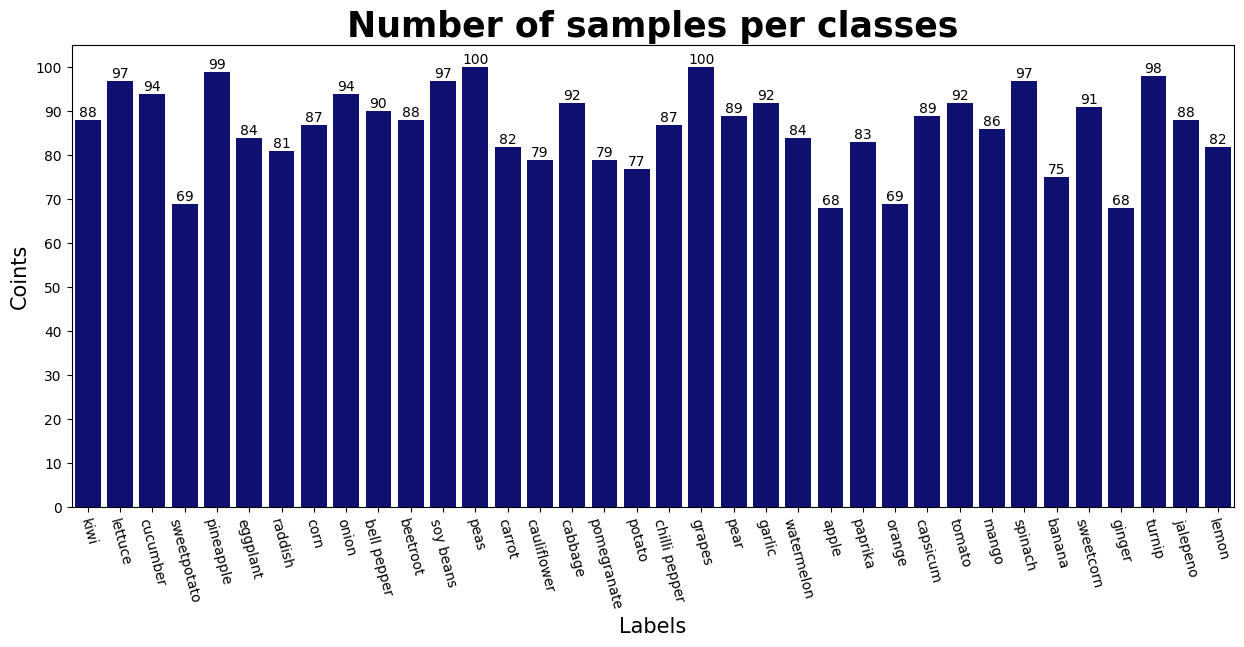

In [19]:
count = []
classes = [class_name for class_name in os.listdir(train_folder)]
for class_name in classes:
  count.append(len(os.listdir(os.path.join(train_folder, class_name))))

plt.figure(figsize = (15,6))
ax = sns.barplot(x = classes, y=count, color= "navy")
plt.xticks(rotation = 285)
for i in ax.containers:
  ax.bar_label(i,)
plt.title("Number of samples per classes", fontsize=25, fontweight = "bold")
plt.xlabel("Labels", fontsize = 15)
plt.ylabel("Coints",fontsize =15)
plt.yticks(np.arange(0,105,10))
plt.show()

In [20]:
def create_df(folder_path):
  all_image = []
  for class_name in classes:
    class_path = os.path.join(folder_path, class_name)
    all_image.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
  df = pd.DataFrame(all_image, columns = ["file_path","label"])
  return df

In [21]:
train_df = create_df(train_folder)
validation_df = create_df(valid_folder)

In [22]:
print(f"Number of samples in train set: {len(train_df)}")
print(f"Number of samples in valid set: {len(validation_df)}")

Number of samples in train set: 3115
Number of samples in valid set: 351


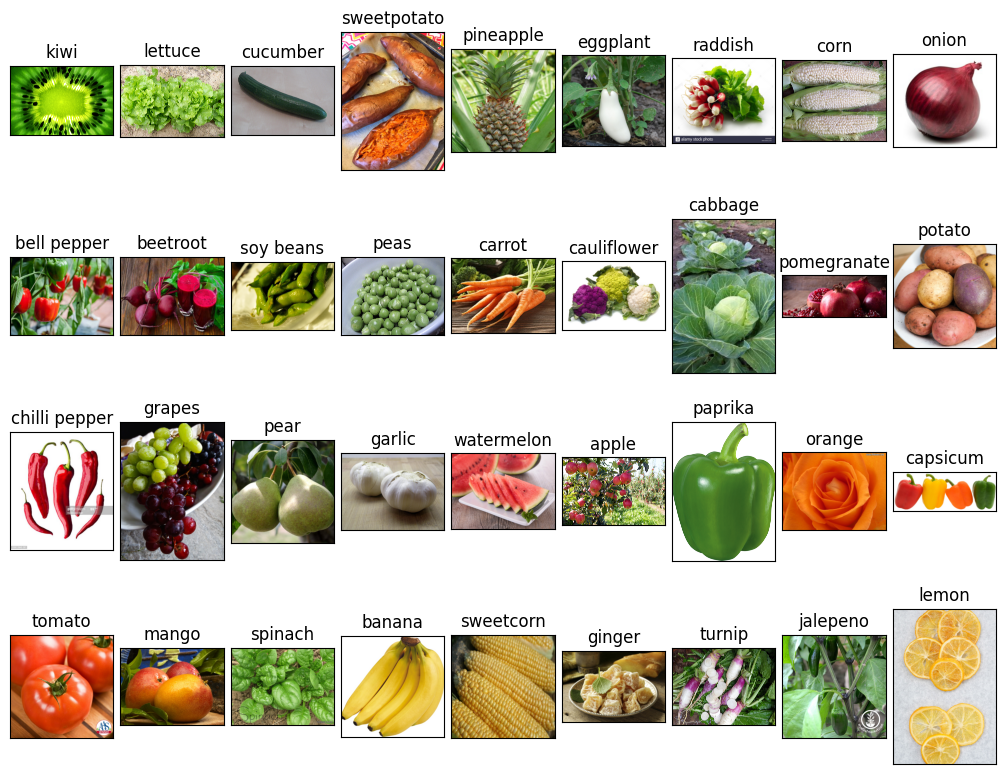

In [23]:
df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index()
fig, axes = plt.subplots(nrows=4, ncols= 9, figsize = (10,8),
                        subplot_kw = {"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(df_unique.file_path[i]))
  ax.set_title(df_unique.label[i], fontsize= 12)

plt.tight_layout(pad=0.5)
plt.show()

In [24]:
from keras.utils import plot_model
from keras.models import Model, load_model
from keras.layers import Conv2D, BatchNormalization, ReLU, DepthwiseConv2D, Input, GlobalAveragePooling2D, Dense, Add, Flatten

from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix

In [25]:
train_datagen = ImageDataGenerator(
  rescale = 1./255,
  rotation_range = 20,
  width_shift_range=0.2,
  height_shift_range=0.2,
  zoom_range=0.1,
  horizontal_flip=True,
  shear_range=0.1,
  fill_mode='nearest'
)

In [26]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),         # Resize images  to
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

Found 3115 validated image filenames belonging to 36 classes.


In [27]:
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),         # Resize images  to
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 351 validated image filenames belonging to 36 classes.


### **Mobile Net V2 from Scratch**

In [ ]:
def expansion_block(x,t,filters,block_id):
    prefix = 'block_{}_'.format(block_id)
    total_filters = t*filters
    x = Conv2D(total_filters,1,padding='same',use_bias=False, name =    prefix +'expand')(x)
    x = BatchNormalization(name=prefix +'expand_bn')(x)
    x = ReLU(6,name = prefix +'expand_relu')(x)
    return x

In [ ]:
def depthwise_block(x,stride,block_id):
    prefix = 'block_{}_'.format(block_id)
    x = DepthwiseConv2D(3,strides=(stride,stride),padding ='same', use_bias = False, name = prefix + 'depthwise_conv')(x)
    x = BatchNormalization(name=prefix +'dw_bn')(x)
    x = ReLU(6,name = prefix +'dw_relu')(x)
    return x

In [ ]:
def projection_block(x,out_channels,block_id):
    prefix = 'block_{}_'.format(block_id)
    x = Conv2D(filters=out_channels,kernel_size = 1,   padding='same',use_bias=False,name= prefix + 'compress')(x)
    x = BatchNormalization(name=prefix +'compress_bn')(x)
    return x

In [ ]:
def Bottleneck(x,t,filters, out_channels,stride,block_id):
    y = expansion_block(x,t,filters,block_id)
    y = depthwise_block(y,stride,block_id)
    y = projection_block(y, out_channels,block_id)
    if y.shape[-1]==x.shape[-1]:
       y = Add()([x, y])
    return y

In [ ]:
def MoblileNetV2(input_shape = (224,224,3)):
  input = Input(input_shape)
  x = Conv2D(32,3,strides=(2,2),padding="same",use_bias = False)(input)
  x = BatchNormalization(name="conv1_bn")(x)
  x = ReLU(6, name="conv1_relu")(x)
  # 17 BottleNecks
  x = depthwise_block(x, stride=1, block_id=1)
  x = projection_block(x, out_channels=16, block_id = 1)
  x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 24, stride = 2,block_id = 2)
  x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 24, stride = 1,block_id = 3)
  x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 2,block_id = 4)
  x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 1,block_id = 5)
  x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 32, stride = 1,block_id = 6)
  x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 2,block_id = 7)
  x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 8)
  x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 9)
  x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 64, stride = 1,block_id = 10)
  x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 96, stride = 1,block_id = 11)
  x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 96, stride = 1,block_id = 12)
  x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 96, stride = 1,block_id = 13)
  x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 2,block_id = 14)
  x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 1,block_id = 15)
  x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 160, stride = 1,block_id = 16)
  x = Bottleneck(x, t = 6, filters = x.shape[-1], out_channels = 320, stride = 1,block_id = 17)
  x = Conv2D(filters = 1280,kernel_size = 1,padding='same',use_bias=False, name = 'last_conv')(x)
  x = BatchNormalization(name='last_bn')(x)
  x = ReLU(6,name='last_relu')(x)
  x = GlobalAveragePooling2D(name='global_average_pool')(x)
  x = Flatten()(x)
  x = Dense(256, activation='relu')(x)
  x = Dense(128, activation='relu')(x)
  output = Dense(36 ,activation='softmax')(x)
  model = Model(input, output)
  return model

In [ ]:
model = MoblileNetV2()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.918924 to fit



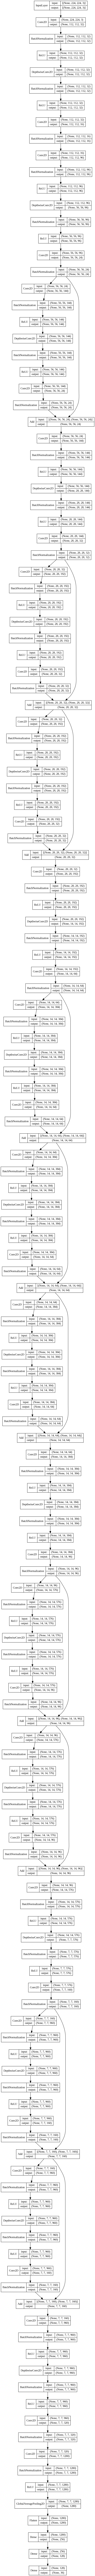

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False,dpi=200)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)         128       ['conv2d[0][0]']              
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['conv1_bn[0][0]']        

In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
# Model CheckPoint
checkpoint_cb = ModelCheckpoint('MyModel.h5', save_best_only=True, verbose=1)

# Early Stoping
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)

Epoch 1/100
98/98 [==============================] - ETA: 0s - loss: 3.4076 - accuracy: 0.0796
Epoch 1: val_loss improved from inf to 3.69475, saving model to MyModel.h5
98/98 [==============================] - 167s 1s/step - loss: 3.4076 - accuracy: 0.0796 - val_loss: 3.6947 - val_accuracy: 0.0285 - lr: 0.0010
Epoch 2/100
98/98 [==============================] - ETA: 0s - loss: 2.9769 - accuracy: 0.1255
Epoch 2: val_loss did not improve from 3.69475
98/98 [==============================] - 128s 1s/step - loss: 2.9769 - accuracy: 0.1255 - val_loss: 4.1633 - val_accuracy: 0.0285 - lr: 0.0010
Epoch 3/100
98/98 [==============================] - ETA: 0s - loss: 2.7201 - accuracy: 0.1852
Epoch 3: val_loss did not improve from 3.69475
98/98 [==============================] - 127s 1s/step - loss: 2.7201 - accuracy: 0.1852 - val_loss: 4.8327 - val_accuracy: 0.0285 - lr: 0.0010
Epoch 4/100
98/98 [==============================] - ETA: 0s - loss: 2.6225 - accuracy: 0.1926
Epoch 4: val_loss did 

In [2]:
model = "/content/MyModel.h5"

In [4]:
import tensorflow as tf
model = tf.keras.models.load_model(model)

In [15]:
# Dự đoán trên tập dữ liệu test
def evaluate_model_performance(model, val_generator, class_labels):

    true_labels = val_generator.classes
    class_labels = list(val_generator.class_indices.keys())
    predictions = model.predict(val_generator, steps=len(val_generator))
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = val_generator.classes
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')
    colors = ["white", "#102C42"]
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(15,10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

11/11 [==============================] - 37s 3s/step
               precision    recall  f1-score   support

        apple       0.86      0.60      0.71        10
       banana       0.78      0.78      0.78         9
     beetroot       0.83      1.00      0.91        10
  bell pepper       0.75      0.67      0.71         9
      cabbage       1.00      0.90      0.95        10
     capsicum       0.58      0.70      0.64        10
       carrot       1.00      1.00      1.00         9
  cauliflower       1.00      1.00      1.00        10
chilli pepper       0.50      0.44      0.47         9
         corn       1.00      0.10      0.18        10
     cucumber       1.00      1.00      1.00        10
     eggplant       0.91      1.00      0.95        10
       garlic       0.83      1.00      0.91        10
       ginger       1.00      0.80      0.89        10
       grapes       1.00      1.00      1.00         9
     jalepeno       0.73      0.89      0.80         9
         ki

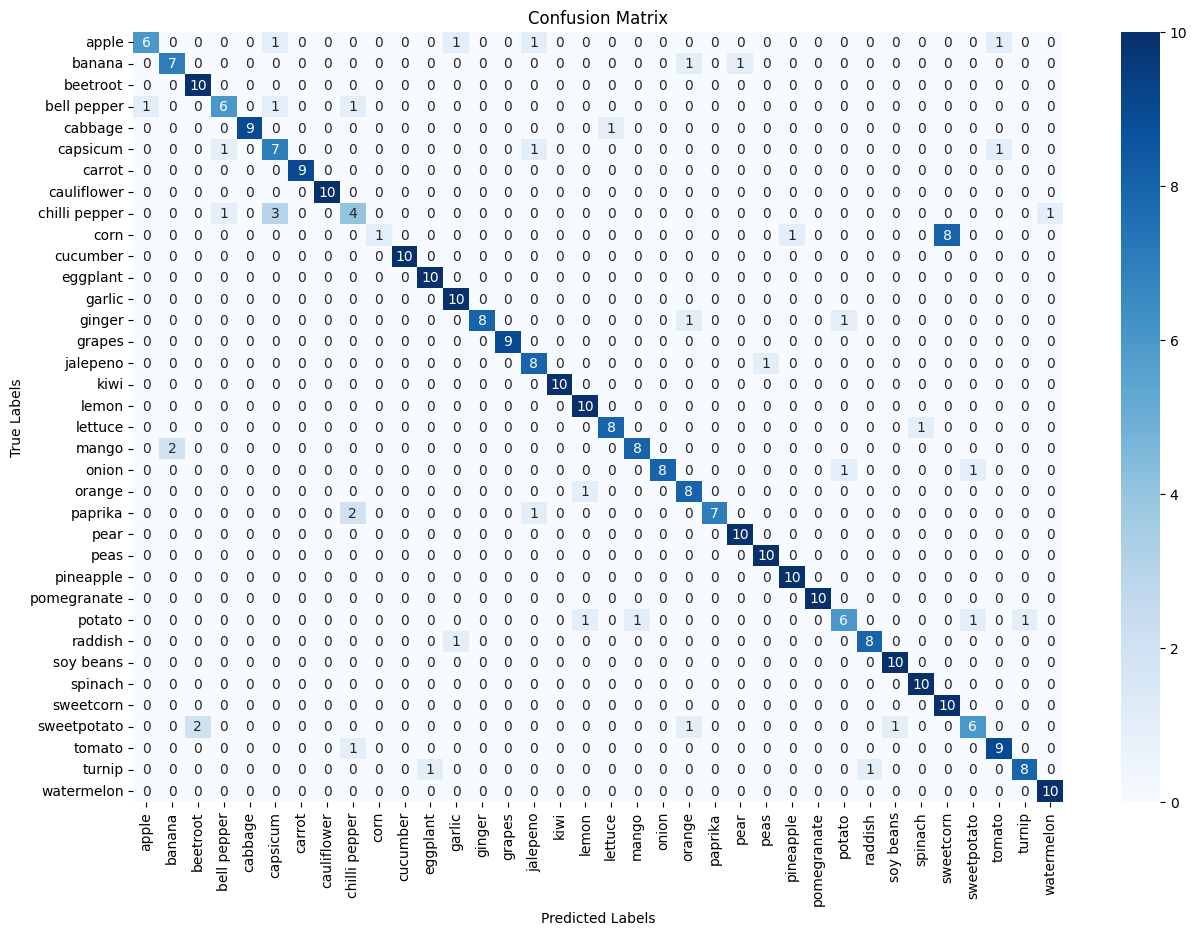

In [28]:
evaluate_model_performance(model, validation_generator, classes)